In [1]:
import os
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, random_split, DataLoader
from torchvision.datasets import ImageFolder
from PIL import Image
import torchvision.models as models
import matplotlib.pyplot as plt
import torchvision.transforms as tt
from sklearn.metrics import f1_score
import torch.nn.functional as F
import torch.nn as nn
from torchvision.utils import make_grid
import random
import shutil
import sklearn

%matplotlib inline

In [ ]:
# upload external file before import
# from google.colab import files
# files.upload()
# import helper

# files.upload()
# import fc_model

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#data_dir="/content/drive/MyDrive/train test different models"
# data_dir="/content/drive/MyDrive/ttdm full dataset/ttdm final"
data_dir="/content/drive/MyDrive/Visible_Vs_Fused/Visible"

In [4]:
train_ds = ImageFolder(data_dir+'/Train', tt.Compose([tt.Resize((224, 224)), tt.ToTensor()]))
valid_ds = ImageFolder(data_dir+'/Validate', tt.Compose([tt.Resize((224, 224)), tt.ToTensor()]))
test_ds = ImageFolder(data_dir+'/Test', tt.Compose([tt.Resize((224, 224)), tt.ToTensor()]))

In [5]:
print(f'Number of training examples: {len(train_ds)}')
print(f'Number of validation examples: {len(valid_ds)}')
print(f'Number of testing examples: {len(test_ds)}')

Number of training examples: 13300
Number of validation examples: 4522
Number of testing examples: 2600


In [6]:
BATCH_SIZE = 64
train_dl = DataLoader(train_ds, shuffle = True, batch_size = BATCH_SIZE)
valid_dl = DataLoader(valid_ds, shuffle = True, batch_size = BATCH_SIZE)
test_dl = DataLoader(test_ds, batch_size = BATCH_SIZE)

In [7]:
def show_batch(dl):
  for images, label in dl:
      # print(images.shape)
      fig, ax = plt.subplots(figsize=(12, 12))
      ax.set_xticks([]); ax.set_yticks([])
      grid_image=make_grid(images[:64],nrow=8)
      # print(grid_image.shape)
      ax.imshow(grid_image.permute(1,2,0))
      break

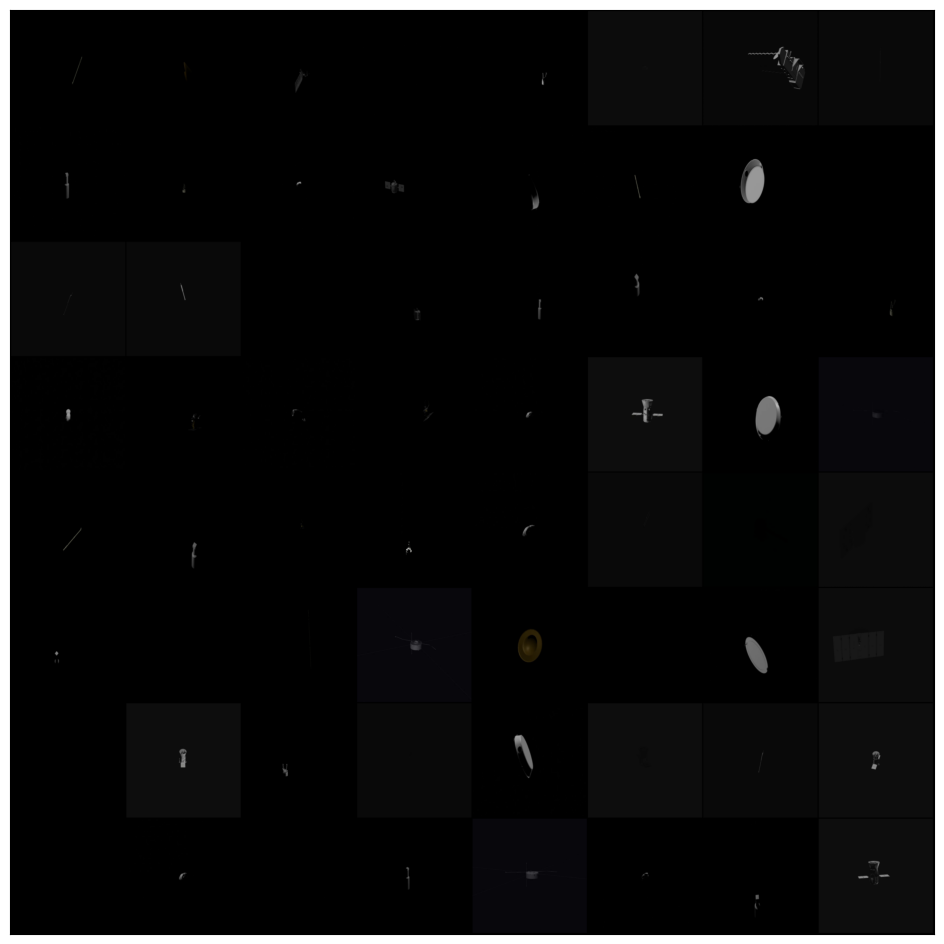

In [8]:
show_batch(train_dl)

In [9]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [10]:
device = get_default_device()
device

device(type='cuda')

In [11]:
train_dl2 = DeviceDataLoader(train_dl, device)
valid_dl2 = DeviceDataLoader(valid_dl, device)
test_dl2 = DeviceDataLoader(test_dl, device)

In [12]:
pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 28.5 MB/s eta 0:00:00


In [13]:
pip install torcheval

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.4/158.4 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.9/87.9 kB 12.6 MB/s eta 0:00:00


In [14]:
import torchvision
from torchvision import models
import torchvision.models.efficientnet as e
import torchvision.models.resnet as r
import torchmetrics
from torchmetrics.classification import F1Score
from torchmetrics.classification import Precision
from torcheval.metrics.functional import multiclass_f1_score

In [17]:
import torch.nn as nn
import torch.nn.functional as F

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def f1score(outputs, labels):
    f1 = F1Score(task="multiclass", num_classes=2).to(device)
    _, preds = torch.max(outputs, dim=1)
    return f1(preds, labels)

def precision(outputs, labels):
    precision = Precision(task="multiclass", num_classes=2).to(device)
    _, preds = torch.max(outputs, dim=1)
    return precision(preds, labels)

class SDDBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels)  # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        prec = precision(out, labels)           # Calculate precision
        f1 = f1score(out, labels)             # Calculate f1 score
        return {'val_loss': loss.detach(), 'val_acc': acc, 'precision': prec, 'f1score': f1}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        batch_precision= [x['precision'] for x in outputs]
        epoch_precision = torch.stack(batch_precision).mean()   # Combine precision
        batch_f1= [x['f1score'] for x in outputs]
        epoch_f1 = torch.stack(batch_f1).mean()   # Combine f1
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item(), 'precision': epoch_precision.item(),'f1score': epoch_f1.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}],{} train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f},precision: {:.4f}, f1score: {:.4f}".format(
            epoch, "last_lr: {:.5f},".format(result['lrs'][-1]) if 'lrs' in result else '', 
            result['train_loss'], result['val_loss'], result['val_acc'], result['precision'], result['f1score']))

In [19]:
from torchvision import models
class SDDModel(SDDBase):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        # Use a pretrained model
        self.network = models.googlenet(pretrained=True)
        # Replace last layer
        self.network.fc = nn.Linear(1024, 2)

    def forward(self, xb):
        return self.network(xb)


In [20]:
model_googleNet=torch.load('/content/drive/MyDrive/GoogLeNetmodel.pth') #if the model.pth file is uploaded in /content

In [21]:
import torch
from tqdm.notebook import tqdm

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader] 
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
# model2 = SDDModel(len(train_ds.classes))
# # len(train_ds.classes)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 328MB/s]


In [22]:
to_device(model_googleNet, device);

In [23]:
history = [evaluate(model_googleNet, valid_dl2)]
history

[{'val_loss': 4.403450965881348,
  'val_acc': 0.5150695443153381,
  'precision': 0.5150695443153381,
  'f1score': 0.5150695443153381}]

In [24]:
model2 = SDDModel(len(train_ds.classes))
# len(train_ds.classes)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:01<00:00, 46.2MB/s]


In [25]:
to_device(model2, device);

In [26]:
epochs = 5
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [27]:
%%time
history += fit_one_cycle(epochs, max_lr, model2, train_dl2, valid_dl2, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

  0%|          | 0/208 [00:00<?, ?it/s]

Epoch [0],last_lr: 0.00759, train_loss: 0.4217, val_loss: 1.2354, val_acc: 0.4942,precision: 0.4942, f1score: 0.4942


  0%|          | 0/208 [00:00<?, ?it/s]

Epoch [1],last_lr: 0.00950, train_loss: 0.4539, val_loss: 1.9811, val_acc: 0.4946,precision: 0.4946, f1score: 0.4946


  0%|          | 0/208 [00:00<?, ?it/s]

Epoch [2],last_lr: 0.00611, train_loss: 0.4431, val_loss: 2.0951, val_acc: 0.3497,precision: 0.3497, f1score: 0.3497


  0%|          | 0/208 [00:00<?, ?it/s]

Epoch [3],last_lr: 0.00188, train_loss: 0.4057, val_loss: 1.8213, val_acc: 0.3603,precision: 0.3603, f1score: 0.3603


  0%|          | 0/208 [00:00<?, ?it/s]

Epoch [4],last_lr: 0.00000, train_loss: 0.3913, val_loss: 1.9928, val_acc: 0.3408,precision: 0.3408, f1score: 0.3408
CPU times: user 31min 52s, sys: 46.1 s, total: 32min 38s
Wall time: 2h 50min 47s


In [28]:
def test_images(test_loader, model):
  test_result={}
  test_result = evaluate(model, test_loader)
  print(test_result)

In [29]:
test_images(test_dl2, model2)

{'val_loss': 2.829986810684204, 'val_acc': 0.6112805008888245, 'precision': 0.6112804412841797, 'f1score': 0.6112804412841797}


In [ ]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return train_ds.classes[preds[0].item()]

Label: debris , Predicted: debris


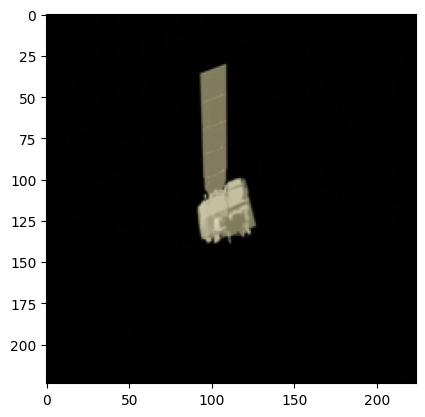

In [ ]:
img, label = test_ds[100]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model2))

In [ ]:
history

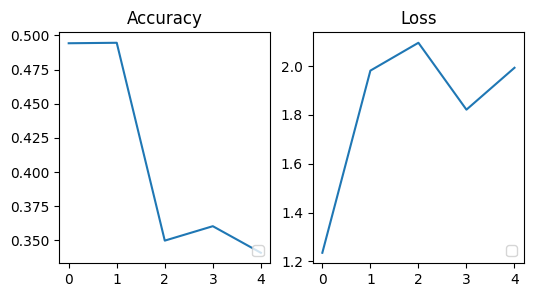

In [30]:
val_acc =[]
val_loss =[]
loss =[]

for i in range(1,len(history)):
  val_acc.append(history[i].get('val_acc'))
  val_loss.append(history[i].get('val_loss'))
  loss.append(history[i].get('train_loss'))

epochs_range = range(epochs)

plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
#plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc) #label='Validation Accuracy'
plt.legend(loc='lower right')
plt.title('Accuracy')

plt.subplot(1, 2, 2)
#plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss) #, label='Validation Loss'
plt.legend(loc='lower right')
plt.title('Loss')
plt.show()

# New Section

In [31]:
PATH="/content/"
torch.save(model2, PATH+'visible_results_model.pth')

In [ ]:
model2=torch.load(PATH+'model.pth') #if the model.pth file is uploaded in /content